## RandomForest

### Introduction

Pros: Relatively fast speed, High prediction performance in diverse region  
Base: DecisionTree -> Easy and Intutive  
Algorithm: Bagging multiple DTs -> Softvoting DTs  
Bagging = Bootstrap Aggregating  

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])

    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply\
                                        (lambda x: x[0]+'_'+str(x[1]) if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [3]:
def get_human_dataset():
    feature_name_df = pd.read_csv(r'.\UCI HAR Dataset\features.txt', sep='\s+', 
                                  header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    X_train = pd.read_csv(r'.\UCI HAR Dataset\train\X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv(r'.\UCI HAR Dataset\test\X_test.txt', sep='\s+', names=feature_name)
    y_train = pd.read_csv(r'.\UCI HAR Dataset\train\y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(r'.\UCI HAR Dataset\test\y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
RF = RandomForestClassifier(random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
acc = accuracy_score(y_test, pred)
print('Accuracy of RandomForest:', np.round(acc, 4))

Accuracy of RandomForest: 0.9253


### Hyperparamter Tuning

Cons: Too many Hyperparameters  
n_estimator: # of DT in RF, Default:10  
max_features: same as DT, but Default:sqrt(auto)  
max_depth, min_samples_leaf = same as DT

In [7]:
params = {'n_estimators':[100],
          'max_depth':[6,8,10,12],
          'min_samples_leaf':[8,12,18],
          'min_samples_split':[8,16,20]}

RF = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(estimator=RF, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('Optimal Hyperparameters:\n', grid_cv.best_params_)
print('Best Accuracy:', np.round(grid_cv.best_score_,4))

Optimal Hyperparameters:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
Best Accuracy: 0.918


In [8]:
RF300 = RandomForestClassifier(max_depth=10, min_samples_leaf= 8,
                               min_samples_split=8, n_estimators=300, random_state=0)
RF300.fit(X_train, y_train)
pred = RF300.predict(X_test)
acc = accuracy_score(y_test, pred)
print('Accuracy:', np.round(acc,4))

Accuracy: 0.9165


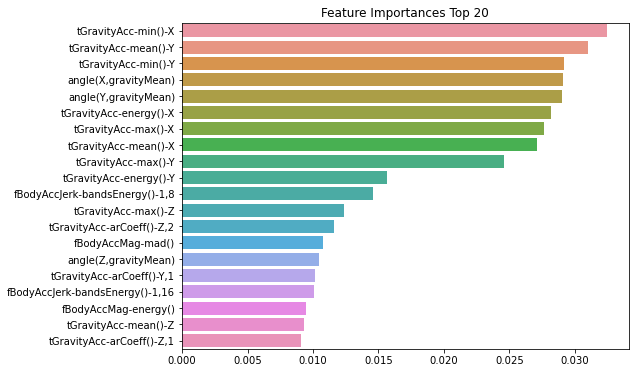

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

feature_importance_values = RF300.feature_importances_
feature_importance = pd.Series(feature_importance_values, index=X_train.columns)
top20_features = feature_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 20')
sns.barplot(x=top20_features, y=top20_features.index)
plt.show()

## GBM(Gradinet Boosting Machine)

### Introduction

Boosting Alogrithm  
make multiple 'weak learner' -> Sequentially Learning(for data that made wrong prediction, impose weight) -> improve error!  
AdaBoost: One of the most popular Boosting Model  
GBM: Use Gradient Descent for weight update

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
import time

start_time = time.time()

GBM = GradientBoostingClassifier(random_state=0)
GBM.fit(X_train, y_train)
pred = GBM.predict(X_test)
acc = accuracy_score(y_test, pred)

print('Accuracy of GBM:', np.round(acc,4))
print('Exectution time of GBM:', np.round(time.time()-start_time))

Accuracy of GBM: 0.9389
Exectution time of GBM: 754.0


### Hyperparameter Tuning for GBM

loss: Select loss function for Gradient Descent, Default: deviance  
learning_rate: Learning_rate, Default: 0.1  
n_estimator: # of weak learners, Default: 100  
subsample: Ratio of Data Sampling, Default: 1

In [5]:
params = {'n_estimators':[100,500],
          'learning_rate':[0.05, 0.1]}

grid_cv = GridSearchCV(estimator=GBM, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)

print('Optimal Hyperparameters:\n', grid_cv.best_params_)
print('Best Accuracy:', np.round(grid_cv.best_score_,4))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Optimal Hyperparameters:
 {'learning_rate': 0.05, 'n_estimators': 500}
Best Accuracy: 0.9002


In [6]:
bestGBM = grid_cv.best_estimator_
bestGBM.fit(X_train, y_train)
pred = bestGBM.predict(X_test)
acc = accuracy_score(y_test, pred)
print('Accuracy:', np.round(acc,4))

Accuracy: 0.9393
